# Construisez un modèle de scoring

## Introduction

<div>
    <img src="attachment:047468cf-6efb-4420-806c-4a155f3a7a3e.png" width="500"/>
</div>

**Mon rôle:** Data Scientist  
**Nom de la société**: Prêt à dépenser  
**Service de la société**: Propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt.

**Mission**: Aider à décider si un prêt peut être accordé à un client.  
Mettre en œuvre un algorithme de classification de “scoring crédit” qui calcule la probabilité qu’un client le rembourse ou non.  
Puis classifie la demande : crédit accordé ou refusé.

**Utilisateurs**: Chargés de relation client.

**Remarques**: Le modèle doit être facilement interprétable et doit disposer d’une mesure de l’importance des variables pour définir la probabilité.

---

**Fichiers d'entrée**:
- [10 fichiers CSV](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip)
- [Explication de chaque fichier](https://www.kaggle.com/c/home-credit-default-risk/data)
- [Description des colonnes](../input/HomeCredit_columns_description.csv)

## Importation des différents fichiers

In [150]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display  
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn import svm, metrics
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import warnings  

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import numpy as np
import os
import timeit
import copy

Regardons nos fichiers disponibles:

In [92]:
pd.DataFrame(os.listdir("../input/data/"), columns=["Nom des fichiers"])

,Nom des fichiers
0,application_test.csv
1,HomeCredit_columns_description.csv
2,POS_CASH_balance.csv
3,credit_card_balance.csv
4,installments_payments.csv
5,application_train.csv
6,bureau.csv
7,.ipynb_checkpoints
8,previous_application.csv
9,bureau_balance.csv


- [Description des fichiers](https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook#Data)
- [Description de chaque colonne](./../input/HomeCredit_columns_description.csv)

---

On va se concentrer sur **2 fichiers** qui contiennent le plus de données pour commencer:
- application_test.csv
- application_train.csv

On remarque que le fichier **application_train.csv** est le seul à avoir la colonne TARGET.  
Quand la valeur = 1, le client a eu des difficultés de paiement.  
Quand la valeur = 0, le client n'a pas eu de difficulté.

C'est ce qu'on va chercher à prédire dans les 2 fichiers.

In [93]:
# Load the 2 files
app_train = pd.read_csv('../input/data/application_train.csv')
app_test = pd.read_csv('../input/data/application_test.csv')

print('On observe les lignes et colonnes du fichier de training:', app_train.shape)

On observe les lignes et colonnes du fichier de training: (307511, 122)


Parmis les colonnes existantes, je préfère retirer toute colonnes qui ne sont pas éthiques pour éviter de potentiel bias dans les résultats.  
Je les retire des 2 fichiers.

In [94]:
# Removing unethical columns to remove bias
unethical_columns = [
    "CODE_GENDER", # Gender of the client
    "DAYS_BIRTH", # Client's age in days at the time of application
]

# Dropping unethical columns
app_train.drop(columns=unethical_columns, inplace=True)
app_test.drop(columns=unethical_columns, inplace=True)

app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

J'observe les types de mes différentes variables.

In [95]:
app_train.dtypes.value_counts()

float64    65
int64      40
object     15
dtype: int64

In [96]:
app_train.shape

(307511, 120)

Je remarque que j'ai 15 colonnes de type object, je vais surement devoir les encoder en fonction du nombre de valeurs unique.  
Je vais déjà stocker les colonnes de chaque type dans des variables différentes.

In [97]:
col_type_int64 = app_train.select_dtypes('int64').columns
col_type_float64 = app_train.select_dtypes('float64').columns
col_type_object = app_train.select_dtypes('object').columns

J'affiche les valeurs manquantes pour chaque type.

### Inspection du type Int64

#### _Code de génération de graphique_

In [98]:
def display_percentage_missing_chart(df, xticksRange):
    # Get the missing data in percentage
    missing_data = df.isna().mean() * 100

    # Sort by value asc
    missing_data = missing_data.sort_values()

    # Create the figure
    plt.figure(figsize=(12, 2))

    ## Add horizontal lines
    sns.set_style('whitegrid')

    ## Set a color palette (https://seaborn.pydata.org/tutorial/color_palettes.html)
    colors = sns.color_palette("rocket_r", len(missing_data))

    ## Create the barplot
    sns.barplot(x=missing_data.index, y=missing_data,  palette=colors) # Create the bar plot

    ## Rotate the x labels and only one out of three for better readability
    plt.xticks(rotation=-90,fontsize=8)
    plt.xticks(range(0, len(missing_data.index), xticksRange))

    ## Set the labels
    plt.ylabel('Pourcentage')
    plt.xlabel('Colonnes')
    plt.title('Pourcentage de valeurs manquantes')
    plt.show()

def create_color_palette(values, thresholds, colors):  
    """Create a color palette based on the given thresholds and colors."""  
    color_palette = []  
    for value in values:  
        for i in range(len(thresholds)):  
            if value < thresholds[i]:  
                color_palette.append(colors[i])  
                break  
        else:  
            color_palette.append(colors[-1])  
    return color_palette

def display_graph_missing_data(df, figsize_height):
    # Calculate the missing value percentage and count for each column  
    missing_data = df.isna().mean() * 100  
    missing_count = df.isna().sum()  
    unique_count = df.nunique()
    # Create a DataFrame to store the missing value percentage and count  
    missing_df = pd.DataFrame({"Missing Percentage": missing_data, "Missing Count": missing_count, "Unique Count": unique_count})  

    # Sort the DataFrame by missing percentage in descending order  
    missing_df = missing_df.sort_values(by="Missing Percentage", ascending=False)  
    thresholds = [25, 50, 75, 100]  
    colors = ["#4fff87", "#4fc4ff", "#ffbc4f", "#ff4f4f"]  

    # Map the colors based on the percentage value  

    color_palette = create_color_palette(missing_df["Missing Percentage"], thresholds, colors)  

    plt.figure(figsize=(10, figsize_height)) # Adjust the figure size as per your preference  
    ax = sns.barplot(x="Missing Percentage", y=missing_df.index, data=missing_df, palette=color_palette) # Create a horizontal bar plot  
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    # Add labels and legend to the plot  
    plt.xlabel("Valeurs manquantes en %")  
    plt.ylabel("Colonnes")  
    plt.title("Pourcentage de valeurs manquantes")  

    # Add the count of missing values inside each bar  
    # for i, (value, name) in enumerate(zip(missing_df["Missing Count"], missing_df.index)):  
    #     ax.text(1, i, f" {value} ", va="center")  
    for i, (missing_value, unique_value, name) in enumerate(  
        zip(missing_df["Missing Count"], missing_df["Unique Count"], missing_df.index)  
    ):
        ax.text(1, i, f"Manquant: {missing_value}", va="center")
        ax.text(20, i, f"Unique: {unique_value}", va="center")
    # Create a custom legend  
    legend_labels = [f"{thresholds[i]-25}-{thresholds[i+1]-25}%" if i != len(thresholds)-1 else f"{thresholds[i]-25}+%" for i in range(len(thresholds))]  
    colors_scaled = [plt.cm.colors.to_rgb(color) for color in colors]  
    legend_elements = [plt.Line2D([0], [0], marker="s", color="white", markerfacecolor=colors_scaled[i], markersize=10) for i in range(len(colors))]  
    plt.legend(legend_elements, legend_labels, loc="lower right")
    
    # Display the plot  
    plt.show()

#### Résultat

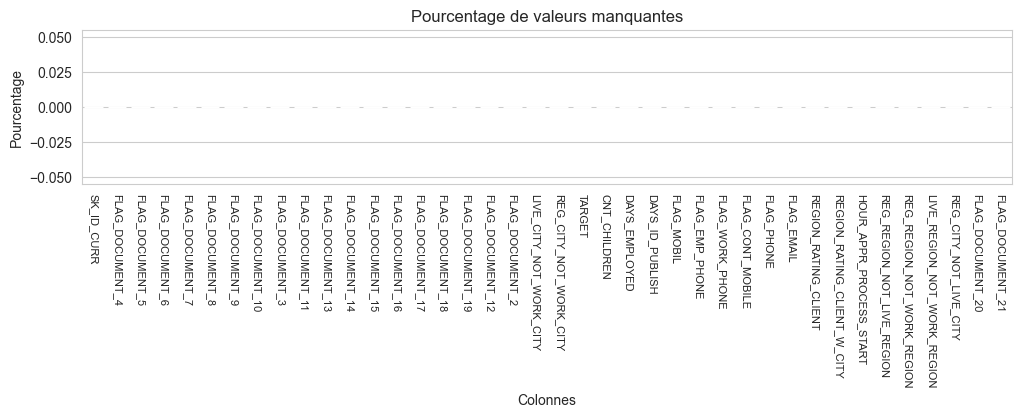

In [99]:
display_percentage_missing_chart(app_train[col_type_int64], 1)

Pas de valeurs manquantes pour les colonnes de type int64, je vais regarder les outliers

In [100]:
# Checking outliers for int64
pd.set_option("display.max_columns", None)
app_train[col_type_int64].describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.080729,0.417052,63815.045904,-2994.202373,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.000042,0.710023,0.000081,0.015115,0.088055,0.000192,0.081376,0.003896,0.000023,0.003912,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335
std,102790.175348,0.272419,0.722121,141275.766519,1509.450419,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499,0.268444,0.421124,0.383817,0.006502,0.453752,0.009016,0.122010,0.283376,0.013850,0.273412,0.062295,0.004771,0.062424,0.002550,0.059268,0.054110,0.03476,0.099144,0.016327,0.089798,0.024387,0.022518,0.018299
min,100002.000000,0.000000,0.000000,-17912.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,-2760.000000,-4299.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,-1213.000000,-3254.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,367142.500000,0.000000,1.000000,-289.000000,-1720.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,2.000000,2.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,456255.000000,1.000000,19.000000,365243.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


J'observe que les colonnes DAYS_EMPLOYED et DAYS_ID_PUBLISH on des valeurs négatives.
Concernant le reste, c'est souvent binaire.

Pour rappel des descriptions:  
	- **DAYS_EMPLOYED**   = `How many days before the application the person started current employment`  
 	- **DAYS_ID_PUBLISH** = `How many days before the application did client change the identity document with which he applied for the loan`

Pour DAYS_EMPLOYED, j'affiche un graphique de distribution des jours employés

#### _Code pour générer les graphiques suivant_

In [101]:
def display_scatter_and_hist_graph_for_column(column_name):
    prds = app_train[column_name].copy().reset_index()  

    # Create a 1x2 grid of subplots  
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))  
      
    # Scatter plot  
    sns.scatterplot(data=prds, x='index', y=column_name, ax=axs[0])  
    axs[0].set_title(f'Scatter Plot de {column_name}')  
    axs[0].set_xlabel('Index')  
    axs[0].set_ylabel(column_name)  
      
    # Histogram  
    app_train[column_name].plot.hist(ax=axs[1], bins=50)  
    axs[1].set_title(f'Histogram de {column_name}')  
    axs[1].set_xlabel(column_name)  
    axs[1].set_ylabel('Fréquence')  
      
    # Adjust the spacing between subplots  
    plt.tight_layout()  
      
    # Show the plot  
    plt.show()  

#### Résultat

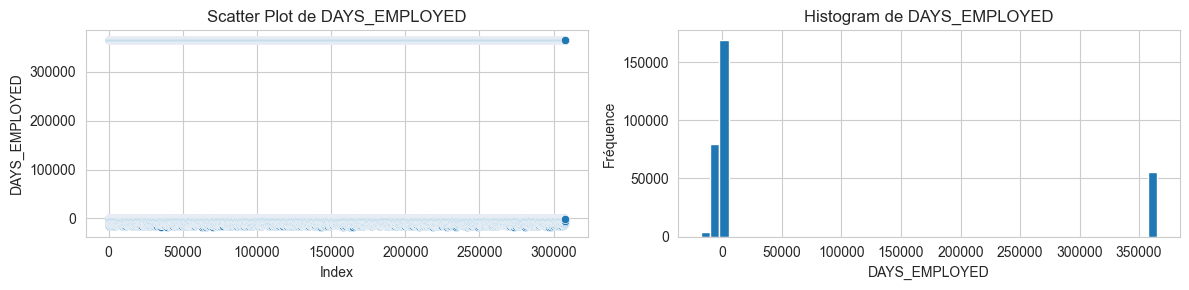

In [102]:
display_scatter_and_hist_graph_for_column("DAYS_EMPLOYED")

Je remarque que +50k valeurs sont égales à 365243.  
Ça m'a l'air d'être une erreur, on ne peut pas être employé 1000ans après avoir fait le demande de crédit, lors de la demande.  
Dans ce cas, je vais les remplacer par NaN pour continuer mon analyse sans bias.

In [103]:
app_train[app_train['DAYS_EMPLOYED'] >= 0]['DAYS_EMPLOYED'].value_counts()
print(f"DAYS_EMPLOYED a {app_train['DAYS_EMPLOYED'].isna().sum()} valeurs NaN")

app_train['DAYS_EMPLOYED'].replace({365243: np.NaN}, inplace = True)
app_test['DAYS_EMPLOYED'].replace({365243: np.NaN}, inplace = True)

# app_train['DAYS_EMPLOYED'].replace({365243: -1}, inplace = True)
# app_train['DAYS_EMPLOYED'].replace({365243: 0}, inplace = True)

print(f"DAYS_EMPLOYED a maintenant {app_train['DAYS_EMPLOYED'].isna().sum()} valeurs NaN")

DAYS_EMPLOYED a 0 valeurs NaN
DAYS_EMPLOYED a maintenant 55374 valeurs NaN


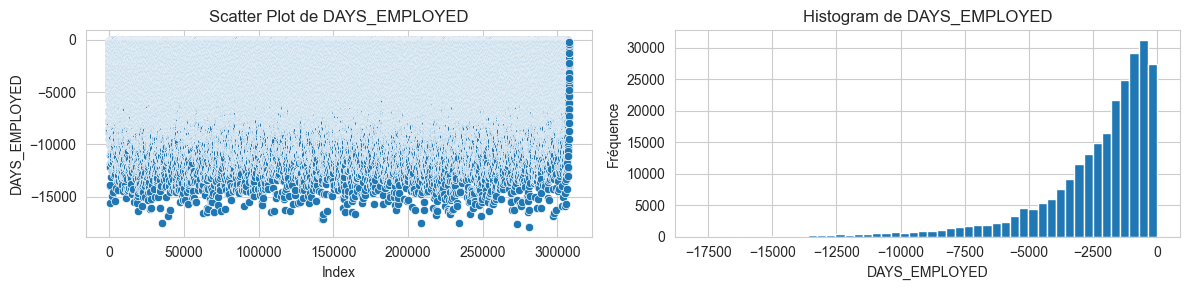

In [104]:
display_scatter_and_hist_graph_for_column("DAYS_EMPLOYED")

Ok ça me parait mieux pour effectuer mon analyse et feature engineering.  
Je vais maintenant observer l'autre colonne DAYS_ID_PUBLISH

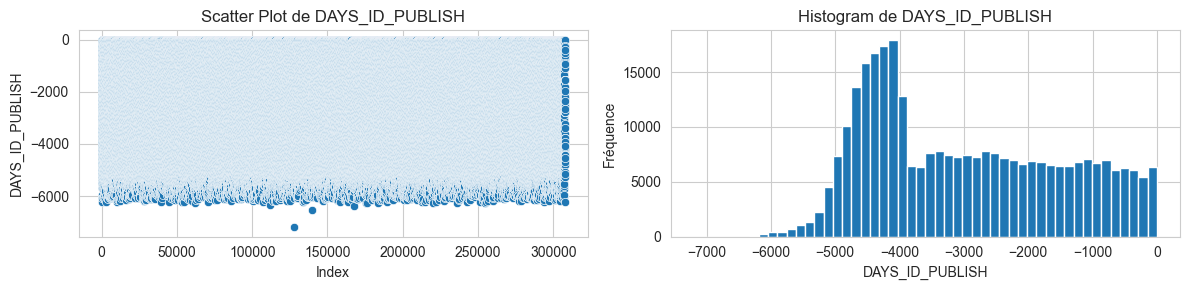

In [105]:
display_scatter_and_hist_graph_for_column("DAYS_ID_PUBLISH")

Pas de valeurs positives, ça me rassure.

### Inspection du type Object

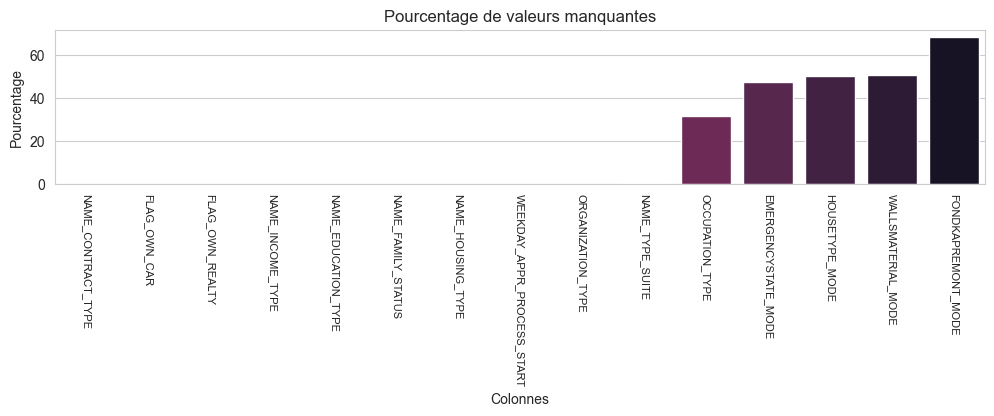

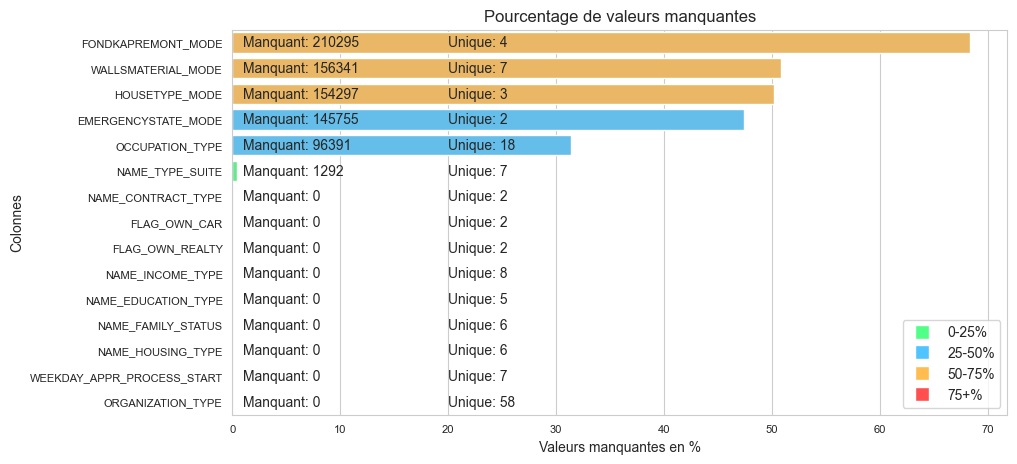

In [106]:
display_percentage_missing_chart(app_train[col_type_object], 1)
display_graph_missing_data(app_train[col_type_object], 5)

Dans ce cas de figure, n'ayant peu de colonnes unique je vais transdformer les colonnes de type object en int64 afin de pouvoir les étudier. 

Je vais utiliser deux méthodes comme défini dans le [kaggle d'exemple fourni](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction): 

- **Label Encoder** : Pour les colonnes qui n'ont que 2 valeurs (afin d'avoir un 1 ou 0),
- **One-Hot encoding**: Pour les colonnes qui ont plus que 2 valeurs, créer une colonnes en plus par valeur unique.

In [107]:
# Label encode object (<= unique type > Label encoder
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # print(
        unique_vals = list(app_train[col].unique())
                 
        if len(unique_vals) <= 2.0:
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col].map(lambda x: x if x in unique_vals else np.nan))
            app_test[col] = le.transform(app_test[col].map(lambda x: x if x in unique_vals else 0))
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d colonnes transformées avec la méthode "label encoded".' % le_count)

3 colonnes transformées avec la méthode "label encoded".


In [108]:
# One-hot encoding for feature with > 2 unique values
print('app_train avant one-hot encoding: ', app_train.shape)
print('app_test avant one-hot encoding: ', app_test.shape)

# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('\napp_train après one-hot encoding: ', app_train.shape)
print('app_test après one-hot encoding: ', app_test.shape)

app_train avant one-hot encoding:  (307511, 120)
app_test avant one-hot encoding:  (48744, 119)

app_train après one-hot encoding:  (307511, 239)
app_test après one-hot encoding:  (48744, 236)


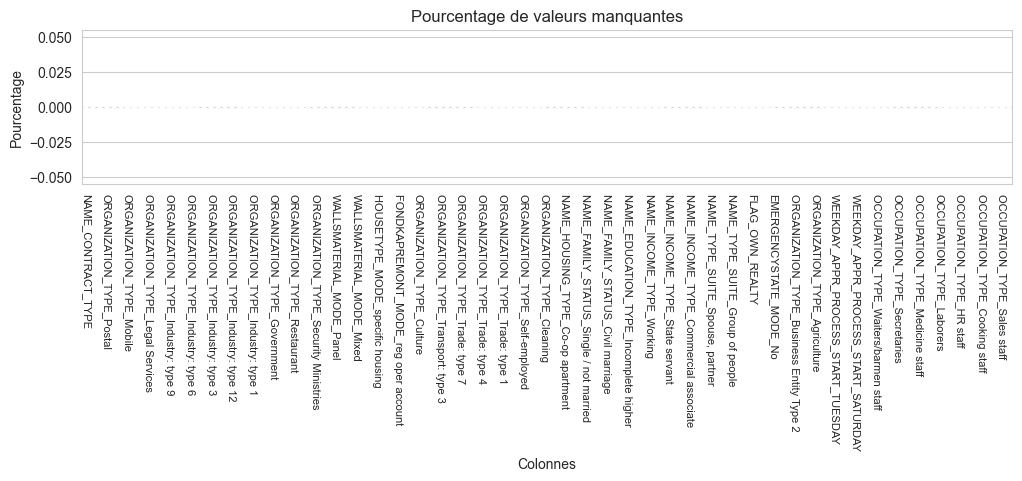

In [109]:
test_data = app_train.drop(columns=col_type_int64).drop(columns=col_type_float64)
display_percentage_missing_chart(test_data, 3)

Comme prévu, pas de valeurs manquantes.

### Inspection du type Float64

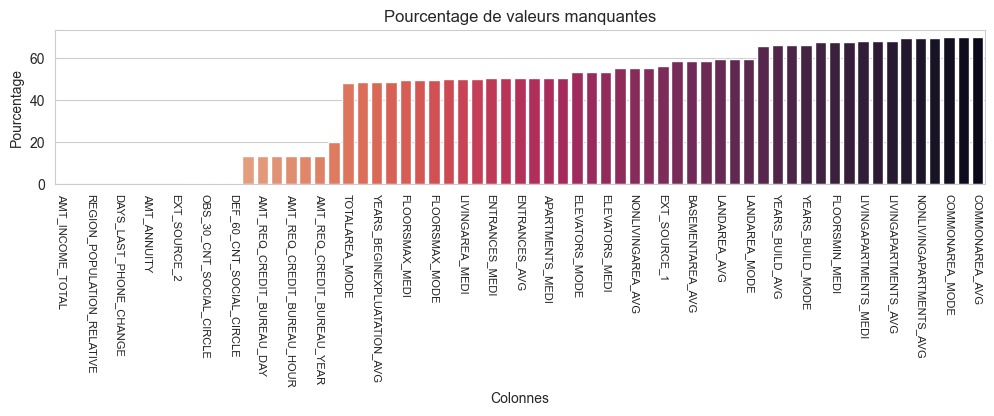

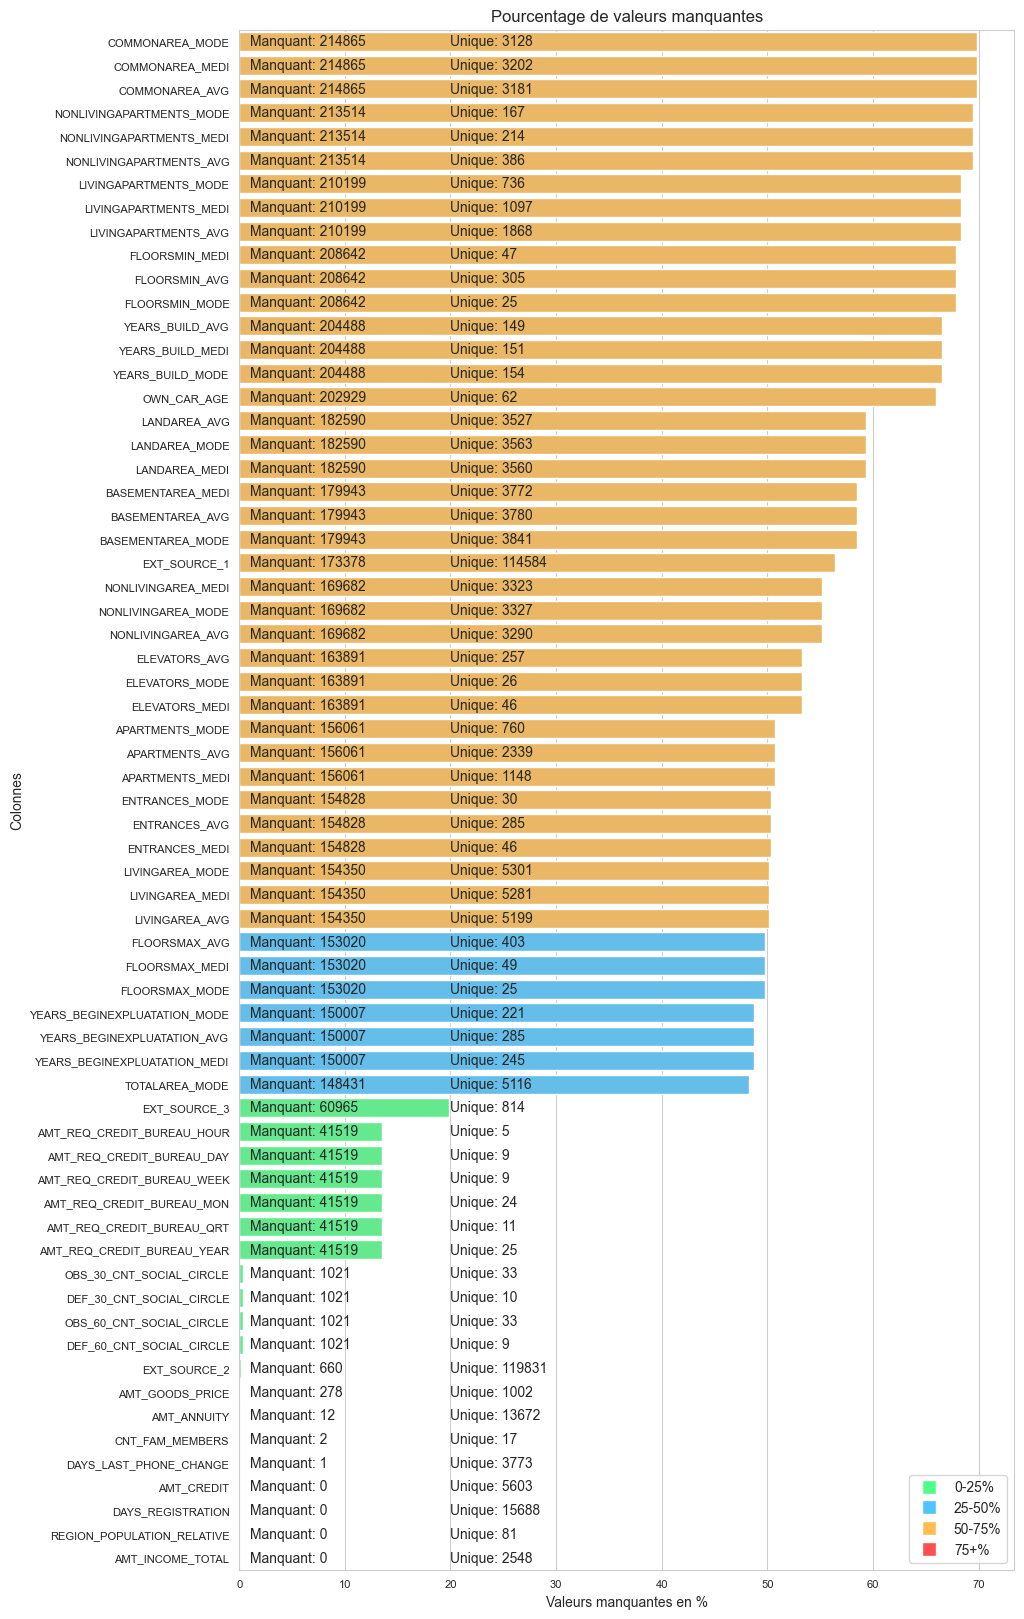

In [110]:
display_percentage_missing_chart(app_train[col_type_float64], 2)
display_graph_missing_data(app_train[col_type_float64], 20)

Beaucoup de valeurs manquantes.  
Je commence par observer les valeurs abérrantes

In [111]:
app_train[col_type_float64].describe()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,104582.000000,307509.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-4986.120328,12.061091,2.152665,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.977752,0.755746,0.044595,0.078078,0.149213,0.225897,0.231625,0.067169,0.101954,0.108607,0.008651,0.028236,0.102547,1.422245,0.143421,1.405292,0.100049,-962.858788,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,3522.886321,11.944812,0.910682,0.211062,1.910602e-01,0.194844,0.10824,0.082438,0.059223,0.113280,0.076036,0.134576,0.100049,0.144641,0.161380,0.081184,0.092576,0.110565,0.047732,0.069523,0.107936,0.084307,0.064575,0.110111,0.074445,0.132256,0.100977,0.143709,0.161160,0.081750,0.097880,0.111845,0.046276,0.070254,0.109076,0.082179,0.059897,0.112066,0.076144,0.134467,0.100368,0.145067,0.161934,0.082167,0.093642,0.112260,0.047415,0.070166,0.107462,2.400989,0.446698,2.379803,0.362291,826.808487,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-24672.000000,0.000000,1.000000,0.014568,8.173617e-08,0.000527,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.125000e+05,2.700000e+05,16524.000000,2.3

Je ne vois pas de valeurs abérrantes, je vais continuer pas observer de features puis je remplacerai les valeurs manquantes

### Observation des features pertinentes

Pour améliorer la detection de correlations et les entrainements de modèles, je vais normaliser les features dans un autre tableau. (Détails dans la description des colonnes)

Je vais maintenant remplacer les valeurs manquantes par différentes méthodes pour analyser le meilleur comportement.
- Suppression total des valeurs manquantes
- Remplacement des valeurs manquantes par la moyenne
- Remplacement des valeurs manquantes par la médiane
- Remplacement des valeurs manquantes par 0

Je vérifie maintenant les correlations entre les features pour voir si je peux réduire en dimension mon dataframe.

#### _Code_

In [112]:
def check_corr(app_train):
    correlations = app_train.corr(numeric_only=True)
    
    # Filter correlations above 0.8 and remove duplicates  
    high_corr = (correlations.abs() >= 0.9) & (correlations.abs() < 1)  
    high_corr_vars = [(var1, var2) for var1 in high_corr.columns for var2 in high_corr.index if high_corr.loc[var1, var2]] 
    
    # Create a list of dictionaries to store the correlation information  
    correlation_data = []  
    printed_vars = set()  # to keep track of already printed pairs  
      
    # Iterate over the high correlated variables and add the information to the list  
    for var1, var2 in high_corr_vars:  
        # Check if var1 is less than var2 and the pair hasn't been added before  
        if (var1, var2) not in printed_vars and (var2, var1) not in printed_vars:  
            correlation_data.append({  
                'Variable 1': var1,  
                'Variable 2': var2,  
                'Correlation': correlations.loc[var1, var2]  
            })  
            printed_vars.add((var1, var2))  # add the pair to printed_vars  
      
    # Convert the list of dictionaries to a DataFrame  
    correlation_table = pd.DataFrame(correlation_data)  
      
    # Sort the DataFrame by correlation values in descending order  
    correlation_table = correlation_table.sort_values(by='Correlation', ascending=False)  
    correlation_table.reset_index(drop=True, inplace=True)  
    return correlations
pd.set_option('display.max_rows', None)

def get_target_correlations(df, graph=True):
    dataframe = df.copy()
    correlations = check_corr(dataframe)

    if graph == False:
        return correlations
    
    # Sort the correlations in ascending order  
    sorted_corr = correlations["TARGET"].sort_values().drop("TARGET")
    
    # Get the top 15 positive correlated values  
    top_positive_corr = sorted_corr[-10:]  
      
    # Get the top 15 negative correlated values  
    top_negative_corr = sorted_corr[:10]  
    
    # Create subplots for both tables  
    fig, axes = plt.subplots(1, 2, figsize=(25, 8))  
      
    # Define a color palette  
    color_palette = sns.color_palette("coolwarm", len(top_positive_corr))  
    
    axes[0].barh(top_positive_corr.index, top_positive_corr.values, color=color_palette)  
    axes[0].set_title("Top 10 correlations positives")  
      
    # Plot the top negative correlated values  
    axes[1].barh(top_negative_corr.index, top_negative_corr.values, color=color_palette[::-1])  
    axes[1].set_title("Top 10 correlations négatives")  
    
    plt.subplots_adjust(wspace=0.4)  
    plt.show()
    
    return correlations

#### Résultat

#### Corrélations avec TARGET

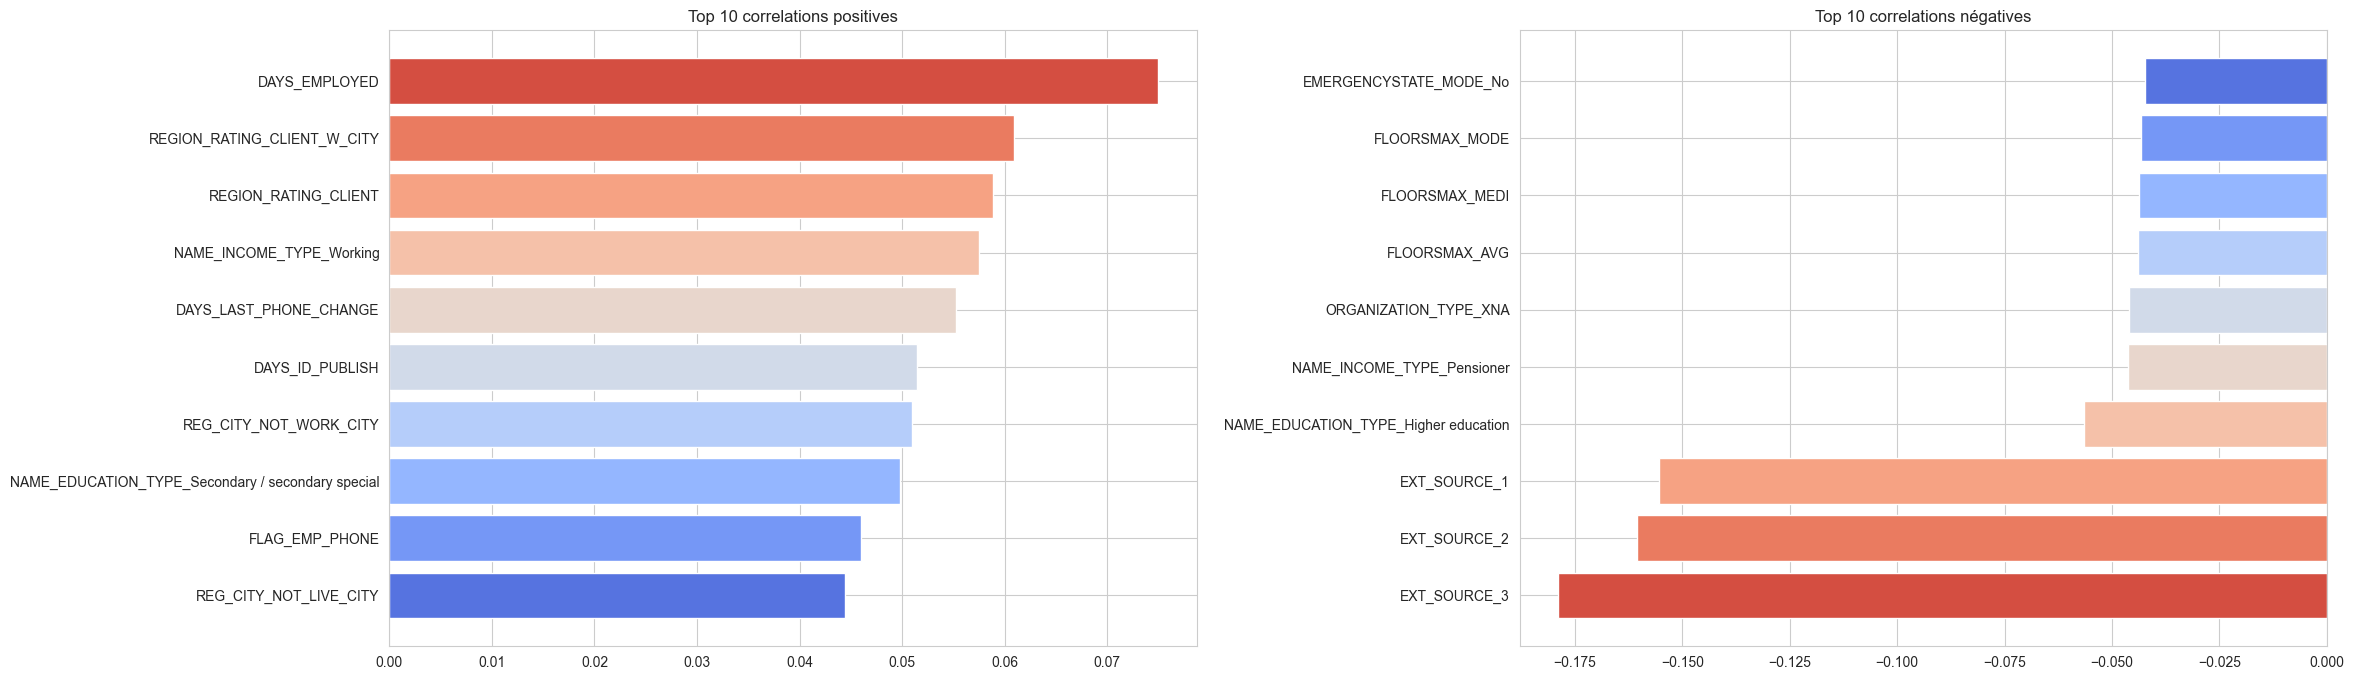

In [113]:
corr = get_target_correlations(app_train)

In [114]:
app_train.shape

(307511, 239)

In [115]:
# _TODO TEXT EXPLICATIF_

def test_sum_living_features(dataframe):
    df = dataframe.copy()
    living_features = [ 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI',  'TOTALAREA_MODE']
    # Compute the sum of the numerical columns  
    df['sum_living_features'] = df[living_features].sum(axis=1)
    
    # Drop the original columns  
    df.drop(columns=living_features, inplace=True)
    return df

def test_sum_flag_documents(dataframe):
    df = dataframe.copy()
    flag_documents = ['FLAG_DOCUMENT_2','FLAG_DOCUMENT_3','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7','FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13','FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16','FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21']

    # Compute the sum of the numerical columns  
    df['sum_flag_documents'] = df[flag_documents].sum(axis=1)
    
    # Drop the original columns  
    df.drop(columns=flag_documents, inplace=True)
    return df


def test_sum_flag_contacts(dataframe):
    df = dataframe.copy()
    flag_contact = ['FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL']

    # Compute the sum of the numerical columns  
    df['sum_flag_contacts'] = df[flag_contact].sum(axis=1)
    
    # Drop the original columns  
    df.drop(columns=flag_contact, inplace=True)
    return df

In [174]:
df_functions = {  
    "sum_living_features": test_sum_living_features,  
    "sum_flag_documents": test_sum_flag_documents,  
    "sum_flag_contacts": test_sum_flag_contacts,
    "sum_flag_living_contact": lambda df: test_sum_flag_contacts(test_sum_flag_documents(test_sum_living_features(df)))  
}

all_data = {}

all_data["default"] = {}  
all_data["default"]["df"] = app_train.copy()
all_data["default"]["test_df"] = app_test.copy()
print(f"Dataframe default shape = {all_data['default']['df'].shape}")
    
for df_name, func in df_functions.items():  
    all_data[df_name] = {}  
    all_data[df_name]["df"] = func(app_train)  
    all_data[df_name]["test_df"] = func(app_test)  
    print(f"Dataframe {df_name} shape = {all_data[df_name]['df'].shape}")

Dataframe default shape = (307511, 239)
Dataframe sum_living_features shape = (307511, 197)
Dataframe sum_flag_documents shape = (307511, 220)
Dataframe sum_flag_contacts shape = (307511, 234)
Dataframe sum_flag_living_contact shape = (307511, 173)


In [117]:
corr_sum_living_features = get_target_correlations(all_data["sum_living_features"]["df"], False)
corr_sum_flag_documents = get_target_correlations(all_data["sum_flag_documents"]["df"], False)
corr_sum_flag_contacts = get_target_correlations(all_data["sum_flag_contacts"]["df"], False)

In [78]:
print("Correlation sum_living_features: ", corr_sum_living_features["sum_living_features"]["TARGET"])
print("Correlation sum_flag_documents: ", corr_sum_flag_documents["sum_flag_documents"]["TARGET"])
print("Correlation sum_flag_contact: ", corr_sum_flag_contacts["sum_flag_contacts"]["TARGET"])

Correlation sum_living_features:  -0.04630944359839301
Correlation sum_flag_documents:  0.017193412923494727
Correlation sum_flag_contact:  0.02077352046541818


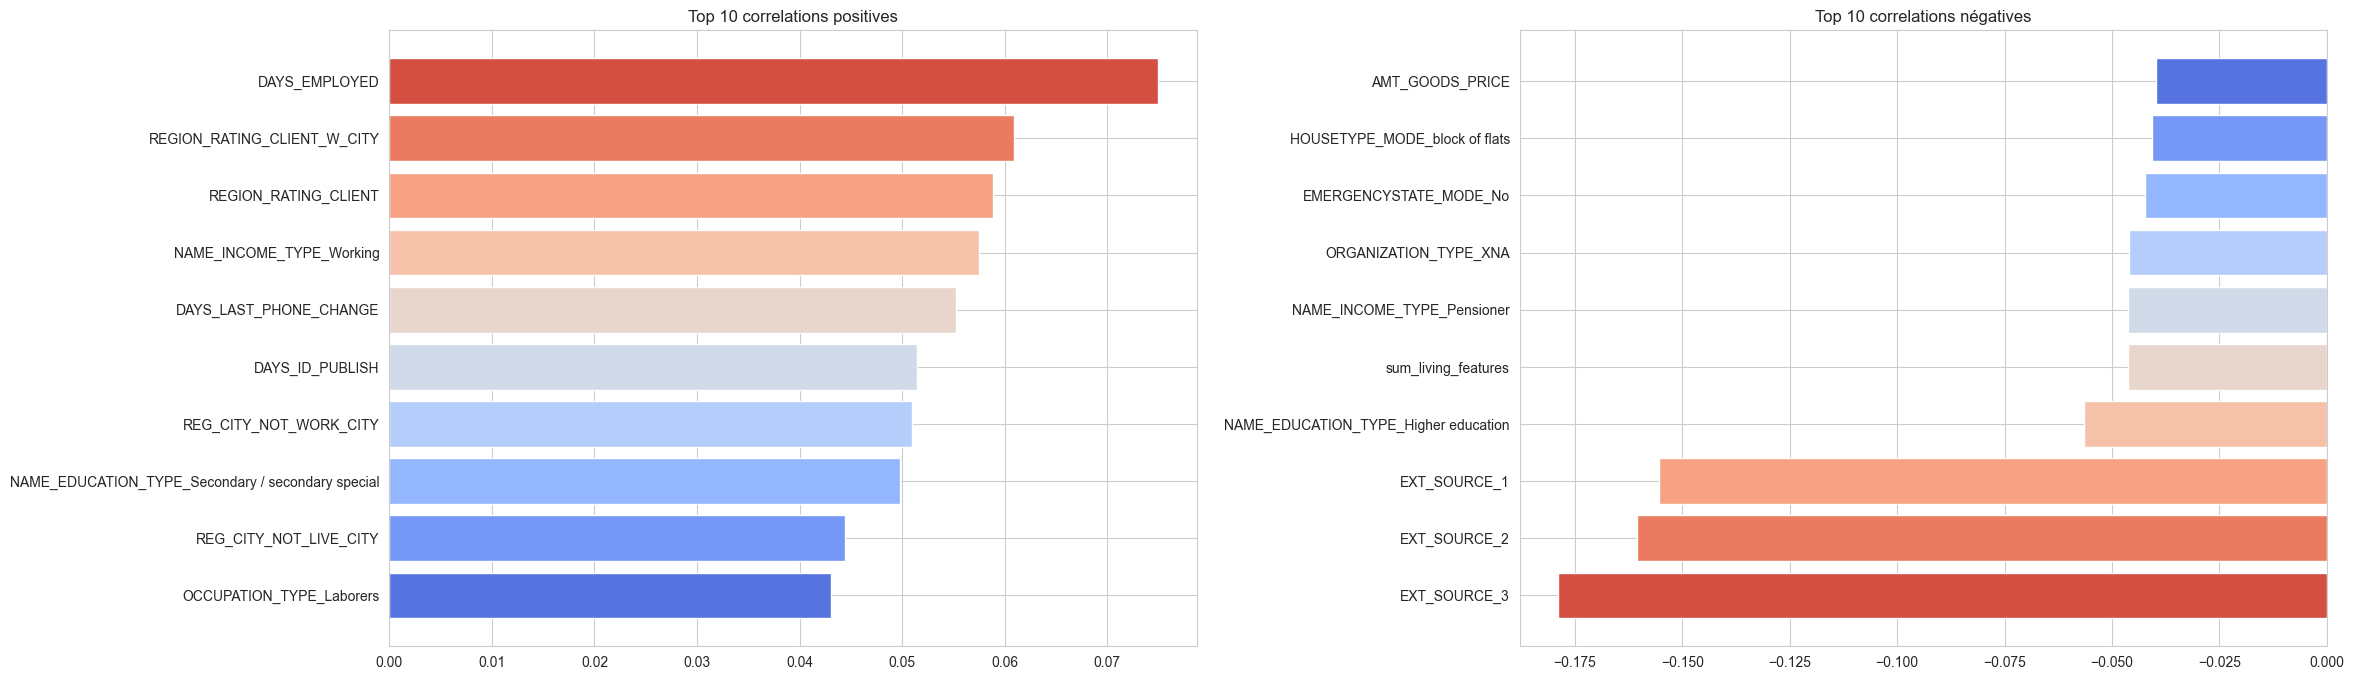

In [79]:
corr_sum_flag_living_contact = get_target_correlations(all_data["sum_flag_living_contact"]["df"])

#### Mutual informations

In [80]:
def make_mi_scores_class(X, y):
    X = X.copy()
    X = X.fillna(X.mean())
    mi_scores = mutual_info_classif(X, y, discrete_features=False, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores, ax, title):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    ax.barh(width, scores)
    ax.set_yticks(width)  
    ax.set_yticklabels(ticks)  
    ax.set_title(title)  

In [81]:
mi_scores_default = make_mi_scores_class(all_data["default"]["df"].drop("TARGET", axis=1), all_data["default"]["df"]["TARGET"])
mi_scores_sum_flag_living_contact = make_mi_scores_class(all_data["sum_flag_living_contact"]["df"].drop("TARGET", axis=1), all_data["sum_flag_living_contact"]["df"]["TARGET"])

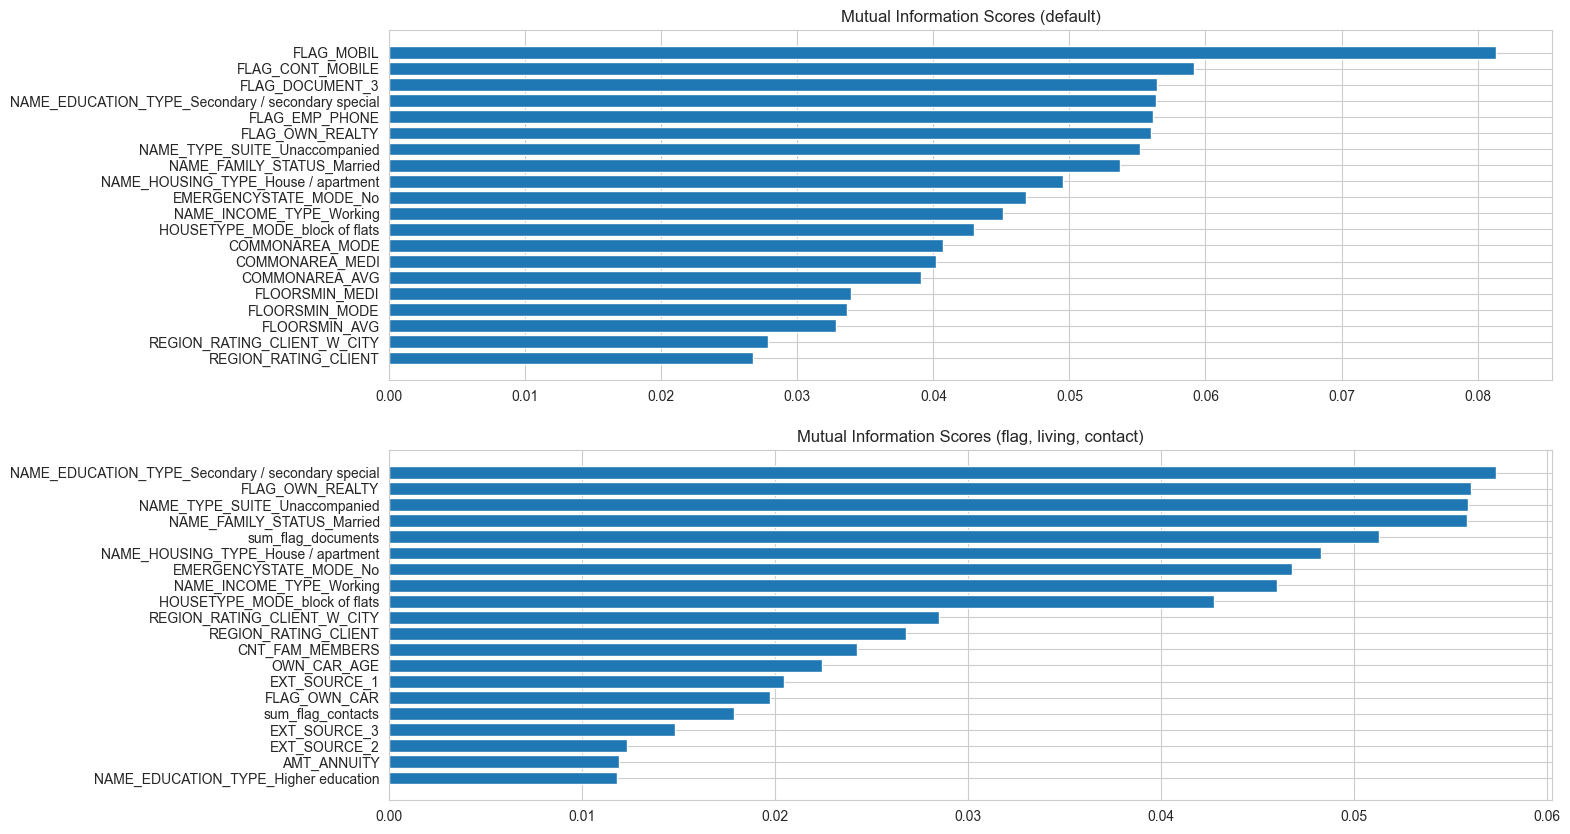

In [82]:
fix, axs = plt.subplots(2, 1, figsize=(15, 10))
plot_mi_scores(mi_scores_default[:20],axs[0],"Mutual Information Scores (default)")
plot_mi_scores(mi_scores_sum_flag_living_contact[:20], axs[1],"Mutual Information Scores (flag, living, contact)")

### Feature Engineering

#### Création de la baseline naïve

TODO text explicatif pour baseline naive

TODO text explicatif pour entrainement model + améliorer visuel


---

Prepare all models

In [122]:

def normalize_per_col(dataframe):
    df = dataframe.copy()
    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return df


def normalize_all_col(dataframe):
    df = dataframe.copy()
    df_flattened = df.values.flatten().reshape(-1, 1)  
    scaler = MinMaxScaler()
    normalized_globally = scaler.fit_transform(df_flattened)  
    df_reshaped = normalized_globally.reshape(-1, len(df.columns))  
    df_normalized_globally = pd.DataFrame(df_reshaped, columns=df.columns)  

    return df_normalized_globally

In [175]:
# Copying the data because the normalization will add more keys
copied_all_data = all_data.copy()

# Loop trhough all and normalize them
for data_name in copied_all_data.keys():
    print(f"Normalizing {data_name} dataframes (per columns & all columns)...")

    # Per columns
    norm_col_name = f"{data_name}_norm_col"
    all_data[norm_col_name] = {}
    all_data[norm_col_name]["df"] = normalize_per_col(all_data[data_name]["df"])
    all_data[norm_col_name]["test_df"] = normalize_per_col(all_data[data_name]["test_df"])

    # All columns
    norm_all_name = f"{data_name}_norm_all"
    all_data[norm_all_name] = {}
    all_data[norm_all_name]["df"] = normalize_all_col(all_data[data_name]["df"])
    all_data[norm_all_name]["test_df"] = normalize_all_col(all_data[data_name]["test_df"])

print("Done")

Normalizing default dataframes (per columns & all columns)...
Normalizing sum_living_features dataframes (per columns & all columns)...
Normalizing sum_flag_documents dataframes (per columns & all columns)...
Normalizing sum_flag_contacts dataframes (per columns & all columns)...
Normalizing sum_flag_living_contact dataframes (per columns & all columns)...
Done


In [177]:
def prepare_dataFrame_for_feature_engineering(d):
    data = copy.deepcopy(d)
    # SK_ID_CURR
    # Save SK_ID_CURR, it's an ID and shouldn't be used for fitting & predicting
    data["test_df_SK_ID_CURR"] = data["test_df"][['SK_ID_CURR']].copy()
    # Drop SK_ID_CURR from dataFrame
    data["df"].drop(columns=['SK_ID_CURR'], inplace=True)
    data["test_df"].drop(columns=['SK_ID_CURR'], inplace=True)

    # Set y
    data["y"] = data["df"]["TARGET"]

    # Align the dataFrames, keep only the columns present in both dataFrames
    data["df_aligned"], data["test_df_aligned"] = data["df"].align(data["test_df"], join='inner', axis=1)
    
    # Set X after aligned df
    data["X"] = data["df_aligned"]
    
    # Split the model into train and test with a test size of 20%
    data["X_train"], data["X_test"], data["y_train"], data["y_test"] = train_test_split(
        data["X"], 
        data["y"],
        test_size=0.2, 
        random_state=42
    )

    # Impute the dataFrame using the mean strategy
    simple_imputer = SimpleImputer(strategy="mean")
    data["X_train"] = pd.DataFrame(simple_imputer.fit_transform(data["X_train"]))
    data["X_train"].columns = data["X"].columns
    
    # Set test separately to avoid train-test contamination
    data["X_test"] = pd.DataFrame(simple_imputer.transform(data["X_test"]))
    data["X_test"].columns = data["X"].columns
    
    # Set the real world test model using the same imputer
    data["test_df_aligned"] = pd.DataFrame(simple_imputer.transform(data["test_df_aligned"]))
    data["test_df_aligned"].columns = data["X"].columns
    data["imputer"] = simple_imputer
    return data



In [176]:
all_data["default"]["df"].head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_T

In [164]:
# Prepare all dataFrames for feature engineering
for data_name in all_data.keys():
    print(f"Preparing {data_name}...")
    all_data[data_name] = prepare_dataFrame_for_feature_engineering(all_data[data_name])
print("Done")

Preparing default...
Preparing sum_living_features...
Preparing sum_flag_documents...
Preparing sum_flag_contacts...
Preparing sum_flag_living_contact...
Preparing default_norm_col...
Preparing default_norm_all...
Preparing sum_living_features_norm_col...
Preparing sum_living_features_norm_all...
Preparing sum_flag_documents_norm_col...
Preparing sum_flag_documents_norm_all...
Preparing sum_flag_contacts_norm_col...
Preparing sum_flag_contacts_norm_all...
Preparing sum_flag_living_contact_norm_col...
Preparing sum_flag_living_contact_norm_all...
Done


In [166]:
all_data["default"]["df"].head()

,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Constru

In [168]:
all_data["default_norm_col"]["df"].head()

,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Constru

In [169]:
all_data["default_norm_all"]["df"].head()

,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Constru

In [ ]:
[key for key in list(all_model.keys())]

['sum_living_features',
 'sum_flag_documents',
 'sum_flag_contact',
 'sum_flag_documents_living_contact',
 'base',
 'sum_living_features_norm_col',
 'sum_living_features_norm_all',
 'sum_flag_documents_norm_col',
 'sum_flag_documents_norm_all',
 'sum_flag_contact_norm_col',
 'sum_flag_contact_norm_all',
 'sum_flag_documents_living_contact_norm_col',
 'sum_flag_documents_living_contact_norm_all',
 'base_norm_col',
 'base_norm_all']

---

In [ ]:
def test_gamma(X_train, X_test, y_train, y_test, gammas, C, axs):
    for gamma in gammas:
        classifier = svm.SVC(C=C,kernel='rbf',gamma=gamma)
        classifier.fit(X_train, y_train)
        y_test_pred = classifier.decision_function(X_test)
        
        fpr, tpr, thre = metrics.roc_curve(y_test, y_test_pred)
        auc = metrics.auc(fpr, tpr)
                
        axs[0].plot(fpr,tpr,'-', lw=2,label='gamma=%f, AUC=%0.2f' % (gamma, auc))
        axs[0].set_xlabel("False positive rate", fontsize=16)
        axs[0].set_ylabel("True positive rate", fontsize=16)
        
        axs[0].set_title("SVM ROC Curve", fontsize=16)
        axs[0].legend(loc="lower right", fontsize=14)

    return plt

def gram_matrix(X_train, gamma, axs):  
    kmatrix = metrics.pairwise.rbf_kernel(X_train, gamma=gamma)  
    kmatrix100 = kmatrix[:100, :100]  
      
    im = axs[1].pcolor(kmatrix100, cmap=cm.PuRd)  
    plt.colorbar(im, ax=axs[1])  
      
    axs[1].set_xlim([0, kmatrix100.shape[0]])  
    axs[1].set_ylim([0, kmatrix100.shape[0]])  
      
    axs[1].invert_yaxis()  
    axs[1].xaxis.tick_top()  

#### BASELINE

In [ ]:
def MSE(y_pred, y_real):
    return np.mean((y_pred - y_real)**2)

def prepare_submission(model, pred, name):
    submit = model["test_model_SK_ID_CURR"]
    submit['TARGET'] = pred
    submit.to_csv(f"./submissions/{name}.csv", index = False)
    
def create_baseline(model, algo_name, algo, model_name):
    ### Baseline for model
    print("Model baseline")

    # Fit the algo
    if algo_name not in model:
        print(f"- Fitting model for {algo_name}...")
        start_time = timeit.default_timer()
        algo.fit(model["X_train"], model["y_train"])
        elapsed = timeit.default_timer() - start_time
        print(f"-- Model fitted in {elapsed:.2f}s")
        model[algo_name] = algo

    # Predict the algo
    algo_name_pred = f"{algo_name}_pred"
    if algo_name_pred not in model:
        print(f"- Predicting data for {algo_name}...")
        start_time = timeit.default_timer()
        model[algo_name_pred] = model[algo_name].predict_proba(model["X_test"])[:, 1]
        elapsed = timeit.default_timer() - start_time
        print(f"-- Data predicted in {elapsed:.2f}s")

    print(f"\n-- MSE:{MSE(model[algo_name_pred], model['y_test'])}")
    
    # print(f"-- accuracy:{accuracy_score(model[algo_name_pred], model['y_test'])}")
    
    ### Baseline for Kaggle submission
    print("- Kaggle baseline export\n\n\n")
    test_proba = model[algo_name].predict_proba(model["test_model"])[:, 1]
    prepare_submission(model, test_proba, f"{model_name}_{algo_name}")

In [ ]:
all_model["sum_living_features_norm_all"]["y_train"].head(10)

123473   -0.296342
10118    -0.296342
64716     3.374485
234940   -0.296342
236051   -0.296342
30611    -0.296342
871      -0.296342
153082   -0.296342
188110   -0.296342
278046   -0.296342
Name: TARGET, dtype: float64

In [ ]:
log_reg = LogisticRegression(C = 0.0001,solver='lbfgs', max_iter=1000)
create_baseline(all_model["sum_living_features_norm_all"], "log_reg",log_reg, "sum_living_features_norm_all")

Model baseline
- Fitting model for log_reg...


ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

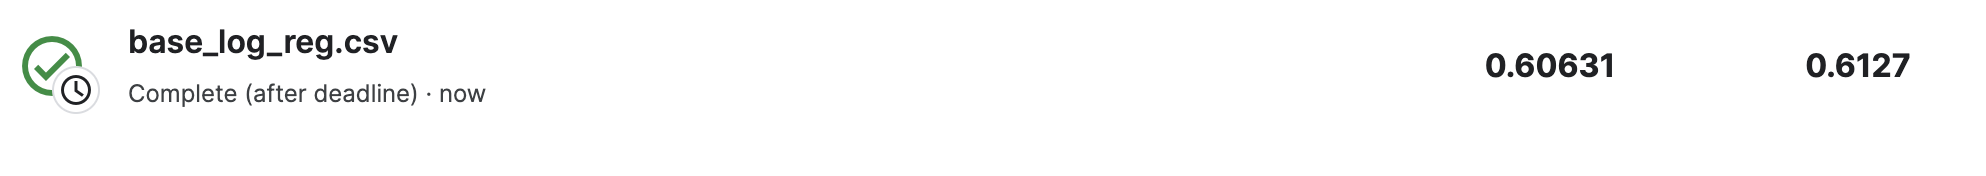

In [ ]:
create_baseline(all_model["base"], "rf_classifier",rf_class, "base")


In [ ]:
# log_reg = LogisticRegression(C = 0.0001,solver='lbfgs', max_iter=1000)
# for model_name, model in models.items():
#     print(f"Doing {model_name}")
#     create_baseline(all_model[model_name], "log_reg",log_reg, model_name)

In [ ]:
rf_class = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs=6)
create_baseline(all_model["base"], "rf_classifier",rf_class, "base")


Model baseline
- Fitting model for rf_classifier...
-- Model fitted in 66.89s
- Predicting data for rf_classifier...
-- Data predicted in 1.14s

-- MSE:0.0699336520169748
- Kaggle baseline export





In [ ]:
data = {  
    'feature': all_model["base"]["test_model"].columns,  
    'importance': all_model["base"]["rf_classifier"].feature_importances_  
}  
  
df = pd.DataFrame(data)  
  
sorted_df = df.sort_values(by='importance', ascending=False)
sorted_df.head(10)

,feature,importance
31,EXT_SOURCE_2,0.050710
32,EXT_SOURCE_3,0.047751
12,DAYS_ID_PUBLISH,0.032890
11,DAYS_REGISTRATION,0.032563
0,SK_ID_CURR,0.031629
10,DAYS_EMPLOYED,0.030831
7,AMT_ANNUITY,0.030462
80,DAYS_LAST_PHONE_CHANGE,0.029198
6,AMT_CREDIT,0.028526
5,AMT_INCOME_TOTAL,0.025227


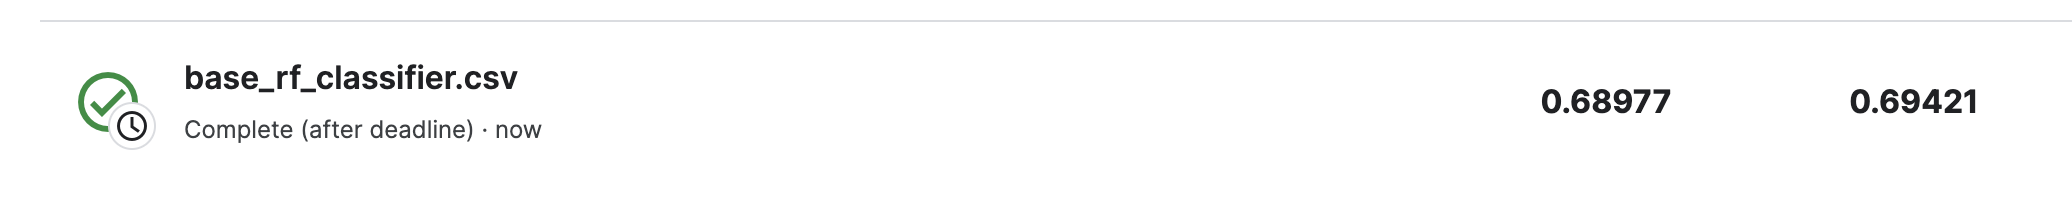

In [ ]:
xgb_class = XGBClassifier(random_state=0)
create_baseline(all_model["base"], "xgb_classifier",xgb_class, "base")

Model baseline
- Fitting model for xgb_classifier...
-- Model fitted in 2.61s
- Predicting data for xgb_classifier...
-- Data predicted in 0.03s

-- MSE:0.06858644989513377
- Kaggle baseline export





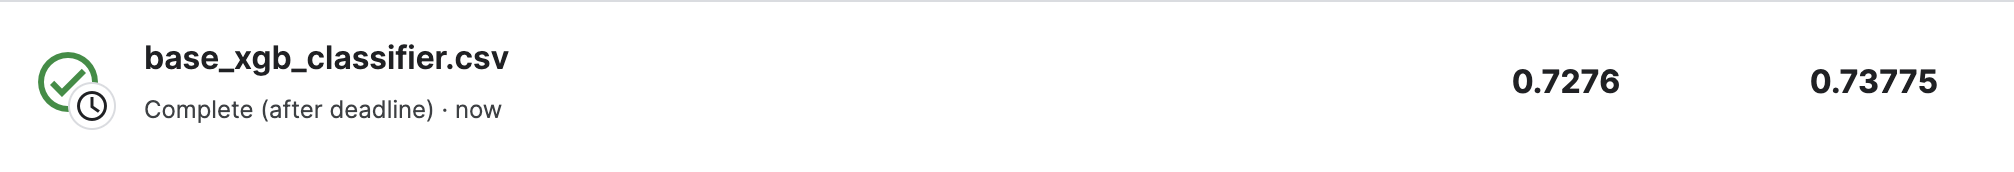

In [ ]:
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="relu")
])

nn_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss="mean_squared_error")

NameError: name 'tf' is not defined

TODO:
Play with:
- Logistic Regression
- RandomForest
- More if I have the time

Next:


- Reduce features and create features based on existing one while reducing dimension.
- Check result and speed improvement.
- Check on Kaggle using the app_test.csv
- Conclusions

A discuter:
> Concernant l’élaboration du modèle soit vigilant sur deux points spécifiques au contexte métier : 
Le déséquilibre entre le nombre de bons et de moins bons clients doit être pris en compte pour élaborer un modèle pertinent, à l’aide d’au moins une méthode au choix

- Todo check actual good vs not good

> Le déséquilibre du coût métier entre un faux négatif (FN - mauvais client prédit bon client : donc crédit accordé et perte en capital) et un faux positif (FP - bon client prédit mauvais : donc refus crédit et manque à gagner en marge)
Tu pourras supposer, par exemple, que le coût d’un FN est dix fois supérieur au coût d’un FP
Tu créeras un score “métier” (minimisation du coût d’erreur de prédiction des FN et FP) pour comparer les modèles, afin de choisir le meilleur modèle et ses meilleurs hyperparamètres. Attention cette minimisation du coût métier doit passer par l’optimisation du seuil qui détermine, à partir d’une probabilité, la classe 0 ou 1 (un “predict” suppose un seuil à 0.5 qui n’est pas forcément l’optimum)

- coût d’un FN est dix fois supérieur au coût d’un FP > (class rebalance TODO):  
TODO > Cout moyen par client

In [ ]:
# TODO class rebalance (Move it before fitting the model)
# from sklearn.utils.class_weight import compute_class_weight

# class_weights = dict(enumerate(compute_class_weight('balanced', np.unique(np.argmax(Y_train, axis=1)), np.argmax(Y_train, axis=1))))

print(f"Good customer = {len(app_train[app_train['TARGET'] == 0])}")
print(f"Bad customer = {len(app_train[app_train['TARGET'] == 1])}")

In [ ]:
# TODO > fit_random_forest_regressor()
# new_model = selected_app_train["model"]
# fit_random_forest_regressor(new_model, selected_app_train["name"], X_train2, y_train)

In [ ]:
# TODO > get_model_precision(selected_app_train["model"], selected_app_train["name"], selected_app_train["X_test"], selected_app_train["y_test"])
# get_model_precision(selected_app_train["model"], selected_app_train["name"], X_train2, y_test)

In [ ]:
# TODO > Evaluate model (f1 score, ...) and update precision matrix

In [ ]:
# Todo > FN x 10 directly in model (easier if you do it manually first)